In [1]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6687414/
2677 + 3457

6134

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
%reload_ext chapyter

2023-09-26 20:21:22.783 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`


In [5]:
#theoretically loads openai credentials from my .env file
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
import os
os.environ["NOTEBOOK_NAME"] = "08-sepsis-gender-distribution.ipynb"

In [7]:
%%mimicSQL --notebook_name 08-sepsis-gender-distribution.ipynb

Retrieve all data from PATIENTS table where patients have “sepsis,” “severe sepsis,” or “septic shock”. Explain what youre doing. Include patient age as a column.

To retrieve the data you're asking for, we'll need to join the `patients` table with the `diagnoses_icd` table. The `diagnoses_icd` table contains the ICD-9 codes for each patient's diagnoses. 

The ICD-9 codes for "sepsis", "severe sepsis", and "septic shock" are 038, 995.92, and 785.52 respectively. However, in the MIMIC-III dataset, the ICD-9 codes are stored without decimals, so we'll use 038, 99592, and 78552.

We'll also calculate the patient's age at the time of their first admission. The `patients` table contains the patient's date of birth, and the `admissions` table contains the date of each admission. By subtracting the date of birth from the date of the first admission, we can calculate the patient's age at the time of their first admission.

Here is the SQL query:

This query will return a table with the patient's ID, gender, date of birth, date of first admission, and age at the time of their first admission. Only patients who have been diagnosed with "sepsis", "severe se

In [8]:
%%runSQL --notebook_name 08-sepsis-gender-distribution.ipynb


SELECT p.subject_id, p.gender, p.dob, MIN(a.admittime) as first_admittime,
    TIMESTAMP_DIFF(MIN(a.admittime), p.dob, YEAR) as age_at_first_admission
FROM patients p
JOIN admissions a ON p.subject_id = a.subject_id
JOIN diagnoses_icd d ON p.subject_id = d.subject_id
WHERE d.icd9_code IN ('038', '99592', '78552')
GROUP BY p.subject_id, p.gender, p.dob


Query failed! State: FAILED
Reason: COLUMN_NOT_FOUND: line 2:45: Column 'year' cannot be resolved or requester is not authorized to access requested resources


AttributeError: 'bool' object has no attribute 'head'

In [9]:
%%mimicSQL --notebook_name 08-sepsis-gender-distribution.ipynb

Why did that last query fail?

The error message indicates that the column 'year' cannot be resolved. This is because the TIMESTAMP_DIFF function you're trying to use does not exist in SQL. 

In SQL, you can calculate the difference between two dates in years by subtracting the year of the first date from the year of the second date. However, this will not account for the difference in months and days between the two dates. 

To get the age at the time of first admission, you can extract the year from the dates and subtract them. If the admission date is earlier in the year than the birth date, you'll need to subtract an additional year.

Here is the corrected SQL query:

This query will return the same columns as before, but now the age at the time of first admission will be calculated correctly.


In [10]:
%%runSQL --notebook_name 08-sepsis-gender-distribution.ipynb


SELECT p.subject_id, p.gender, p.dob, MIN(a.admittime) as first_admittime,
    EXTRACT(YEAR FROM MIN(a.admittime)) - EXTRACT(YEAR FROM p.dob) - 
    CASE 
        WHEN EXTRACT(MONTH FROM MIN(a.admittime)) < EXTRACT(MONTH FROM p.dob) OR 
            (EXTRACT(MONTH FROM MIN(a.admittime)) = EXTRACT(MONTH FROM p.dob) AND 
            EXTRACT(DAY FROM MIN(a.admittime)) < EXTRACT(DAY FROM p.dob)) THEN 1 
        ELSE 0 
    END as age_at_first_admission
FROM patients p
JOIN admissions a ON p.subject_id = a.subject_id
JOIN diagnoses_icd d ON p.subject_id = d.subject_id
WHERE d.icd9_code IN ('038', '99592', '78552')
GROUP BY p.subject_id, p.gender, p.dob


,subject_id,gender,dob,first_admittime,age_at_first_admission
0,711,M,2100-03-06 00:00:00.000,2184-05-04 15:13:00.000,84
1,781,F,2041-08-18 00:00:00.000,2117-08-17 07:15:00.000,75
2,822,M,2145-10-30 00:00:00.000,2174-07-19 08:04:00.000,28
3,124,M,2090-11-19 00:00:00.000,2160-06-24 21:25:00.000,69
4,191,M,2123-02-12 00:00:00.000,2191-12-30 16:34:00.000,68


In [11]:
print(df.shape)

(3710, 5)


In [28]:
%%mimicSQL --notebook_name 08-sepsis-gender-distribution.ipynb

That last query returned a table with only ~3700 patients. I was expecting something closer to 6100 patients. I still only want sepsis patients though. Any ideas how I can get those additional patients? I'm trying to reproduce someone elses work

The discrepancy in the number of patients could be due to the specific ICD-9 codes used to identify sepsis, severe sepsis, and septic shock. Different studies may use different sets of ICD-9 codes to identify these conditions. 

In the MIMIC-III dataset, the ICD-9 codes are stored without decimals, so we used 038, 99592, and 78552. However, there are other ICD-9 codes that could also indicate sepsis, severe sepsis, or septic shock. For example, the ICD-9 code 99591 is for "Sepsis", and the codes 67020 and 67022 are for "Major puerperal infection", which is a type of sepsis that can occur after childbirth.

If you have access to the ICD-9 codes used in the study you're trying to reproduce, you could modify the query to include those codes. If not, you could try including additional ICD-9 codes that are commonly associated with sepsis, severe sepsis, or septic shock.

Here is an example of how you could modify the query to include the additional ICD-9 codes mentioned above:

This query w

In [29]:
%%runSQL --notebook_name 08-sepsis-gender-distribution.ipynb


SELECT p.subject_id, p.gender, p.dob, MIN(a.admittime) as first_admittime,
    EXTRACT(YEAR FROM MIN(a.admittime)) - EXTRACT(YEAR FROM p.dob) - 
    CASE 
        WHEN EXTRACT(MONTH FROM MIN(a.admittime)) < EXTRACT(MONTH FROM p.dob) OR 
            (EXTRACT(MONTH FROM MIN(a.admittime)) = EXTRACT(MONTH FROM p.dob) AND 
            EXTRACT(DAY FROM MIN(a.admittime)) < EXTRACT(DAY FROM p.dob)) THEN 1 
        ELSE 0 
    END as age_at_first_admission
FROM patients p
JOIN admissions a ON p.subject_id = a.subject_id
JOIN diagnoses_icd d ON p.subject_id = d.subject_id
WHERE d.icd9_code IN ('038', '99592', '78552', '99591', '67020', '67022')
GROUP BY p.subject_id, p.gender, p.dob


,subject_id,gender,dob,first_admittime,age_at_first_admission
0,269,M,2130-09-30 00:00:00.000,2170-11-05 11:04:00.000,40
1,736,F,2083-09-14 00:00:00.000,2118-09-19 00:37:00.000,35
2,797,M,2096-11-25 00:00:00.000,2139-08-24 22:00:00.000,42
3,819,M,2045-01-10 00:00:00.000,2116-09-21 01:35:00.000,71
4,21,M,2047-04-04 00:00:00.000,2134-09-11 12:17:00.000,87


In [30]:
print(df.shape)

(4685, 5)


In [34]:
%%mimicSQL --notebook_name 08-sepsis-gender-distribution.ipynb

Getting closer! 4685. Still missing ~1500 pateitns ... where could they be coming from?

The discrepancy might be due to the fact that sepsis can be coded under various ICD-9 codes, not just the ones we have used so far. 

In addition to the primary sepsis codes (038, 99591, 99592, 78552), there are also ICD-9 codes for specific types of sepsis, such as those caused by specific bacteria or other organisms. For example, the ICD-9 codes 0031, 0362, 0380-0389, 0545, 7907, 99591, 99592, 78552, 67020, and 67022 all represent different types of sepsis.

If you're trying to reproduce a study, it would be best to use the same ICD-9 codes that were used in that study. If those aren't available, you could try including more ICD-9 codes that are associated with sepsis.

Here is an example of how you could modify the query to include these additional ICD-9 codes:

This query will return the same columns as before, but it will include patients who have been diagnosed with any of the ICD-9 codes in the list.


In [35]:
%%runSQL --notebook_name 08-sepsis-gender-distribution.ipynb


SELECT p.subject_id, p.gender, p.dob, MIN(a.admittime) as first_admittime,
    EXTRACT(YEAR FROM MIN(a.admittime)) - EXTRACT(YEAR FROM p.dob) - 
    CASE 
        WHEN EXTRACT(MONTH FROM MIN(a.admittime)) < EXTRACT(MONTH FROM p.dob) OR 
            (EXTRACT(MONTH FROM MIN(a.admittime)) = EXTRACT(MONTH FROM p.dob) AND 
            EXTRACT(DAY FROM MIN(a.admittime)) < EXTRACT(DAY FROM p.dob)) THEN 1 
        ELSE 0 
    END as age_at_first_admission
FROM patients p
JOIN admissions a ON p.subject_id = a.subject_id
JOIN diagnoses_icd d ON p.subject_id = d.subject_id
WHERE d.icd9_code IN ('038', '99592', '78552', '99591', '67020', '67022', '0031', '0362', '0380', '0381', '0382', '0383', '0384', '0388', '0389', '0545', '7907')
GROUP BY p.subject_id, p.gender, p.dob


,subject_id,gender,dob,first_admittime,age_at_first_admission
0,269,M,2130-09-30 00:00:00.000,2170-11-05 11:04:00.000,40
1,729,F,2066-07-12 00:00:00.000,2129-12-13 22:47:00.000,63
2,736,F,2083-09-14 00:00:00.000,2118-09-19 00:37:00.000,35
3,797,M,2096-11-25 00:00:00.000,2139-08-24 22:00:00.000,42
4,819,M,2045-01-10 00:00:00.000,2116-09-21 01:35:00.000,71


In [36]:
print(df.shape)

(6429, 5)


In [49]:
%%mimicSQL --notebook_name 08-sepsis-gender-distribution.ipynb

Same table, but include if they died in the hospital or not.

To include whether the patient died in the hospital or not, we can add a column from the `admissions` table. The `hospital_expire_flag` column in the `admissions` table indicates whether the patient died in the hospital (1) or not (0).

Here is the modified SQL query:

This query will return the same columns as before, plus a new column `died_in_hospital` that indicates whether the patient died in the hospital or not.


In [67]:
%%runSQL --notebook_name 08-sepsis-gender-distribution.ipynb


SELECT p.subject_id, p.gender, p.dob, MAX(a.admittime) as first_admittime,
    EXTRACT(YEAR FROM MIN(a.admittime)) - EXTRACT(YEAR FROM p.dob) - 
    CASE 
        WHEN EXTRACT(MONTH FROM MIN(a.admittime)) < EXTRACT(MONTH FROM p.dob) OR 
            (EXTRACT(MONTH FROM MIN(a.admittime)) = EXTRACT(MONTH FROM p.dob) AND 
            EXTRACT(DAY FROM MIN(a.admittime)) < EXTRACT(DAY FROM p.dob)) THEN 1 
        ELSE 0 
    END as age_at_first_admission,
    MAX(a.hospital_expire_flag) as died_in_hospital
FROM patients p
JOIN admissions a ON p.subject_id = a.subject_id
JOIN diagnoses_icd d ON p.subject_id = d.subject_id
WHERE d.icd9_code IN ('038', '99592', '78552', '99591', '67020', '67022', '0031', '0362', '0380', '0381', '0382', '0383', '0384', '0388', '0389', '0545', '7907')
GROUP BY p.subject_id, p.gender, p.dob


,subject_id,gender,dob,first_admittime,age_at_first_admission,died_in_hospital
0,269,M,2130-09-30 00:00:00.000,2170-11-05 11:04:00.000,40,0
1,729,F,2066-07-12 00:00:00.000,2129-12-13 22:47:00.000,63,1
2,736,F,2083-09-14 00:00:00.000,2118-09-19 00:37:00.000,35,0
3,797,M,2096-11-25 00:00:00.000,2139-08-24 22:00:00.000,42,0
4,819,M,2045-01-10 00:00:00.000,2116-09-21 01:35:00.000,71,1


In [68]:
print(df.shape)

(6429, 6)


In [90]:
%%mimicSQL --notebook_name 08-sepsis-gender-distribution.ipynb

Can we include ethnicity in the above table? And marital status? And insurance? And admission type? And admission location?

Yes, we can include those additional columns from the `admissions` table. The `ethnicity`, `marital_status`, `insurance`, `admission_type`, and `admission_location` columns in the `admissions` table contain the information you're asking for.

Here is the modified SQL query:

This query will return the same columns as before, plus the new columns `ethnicity`, `marital_status`, `insurance`, `admission_type`, and `admission_location`.


In [101]:
%%runSQL --notebook_name 08-sepsis-gender-distribution.ipynb


SELECT p.subject_id, p.gender, p.dob, MAX(a.admittime) as first_admittime,
    EXTRACT(YEAR FROM MIN(a.admittime)) - EXTRACT(YEAR FROM p.dob) - 
    CASE 
        WHEN EXTRACT(MONTH FROM MIN(a.admittime)) < EXTRACT(MONTH FROM p.dob) OR 
            (EXTRACT(MONTH FROM MIN(a.admittime)) = EXTRACT(MONTH FROM p.dob) AND 
            EXTRACT(DAY FROM MIN(a.admittime)) < EXTRACT(DAY FROM p.dob)) THEN 1 
        ELSE 0 
    END as age_at_first_admission,
    MAX(a.hospital_expire_flag) as died_in_hospital,
    MAX(a.ethnicity) as ethnicity,
    MAX(a.marital_status) as marital_status,
    MAX(a.insurance) as insurance,
    MAX(a.admission_type) as admission_type,
    MAX(a.admission_location) as admission_location
FROM patients p
JOIN admissions a ON p.subject_id = a.subject_id
JOIN diagnoses_icd d ON p.subject_id = d.subject_id
WHERE d.icd9_code IN ('038', '99592', '78552', '99591', '67020', '67022', '0031', '0362', '0380', '0381', '0382', '0383', '0384', '0388', '0389', '0545', '7907')
GROUP BY p.subject_id, p.gender, p.dob

,subject_id,gender,dob,first_admittime,age_at_first_admission,died_in_hospital,ethnicity,marital_status,insurance,admission_type,admission_location
0,668,F,2096-08-18 00:00:00.000,2183-07-01 08:04:00.000,86,0,WHITE,WIDOWED,Medicare,EMERGENCY,EMERGENCY ROOM ADMIT
1,703,M,2032-03-08 00:00:00.000,2106-08-06 17:09:00.000,72,0,WHITE,MARRIED,Medicare,EMERGENCY,EMERGENCY ROOM ADMIT
2,788,F,2122-07-19 00:00:00.000,2194-01-13 20:48:00.000,71,0,WHITE,WIDOWED,Medicare,EMERGENCY,EMERGENCY ROOM ADMIT
3,801,F,2151-02-17 00:00:00.000,2198-07-09 23:22:00.000,46,0,WHITE,MARRIED,Private,EMERGENCY,TRANSFER FROM HOSP/EXTRAM
4,85,M,2090-09-18 00:00:00.000,2167-07-25 18:49:00.000,71,0,WHITE,MARRIED,Medicare,EMERGENCY,CLINIC REFERRAL/PREMATURE


In [92]:
%%mimicSQL --notebook_name 08-sepsis-gender-distribution.ipynb

Why did you include MAX for all those other attributes?

The `MAX` function was used because we are grouping by `subject_id`, `gender`, and `dob`, but we also want to include other columns that are not included in the `GROUP BY` clause. In SQL, when you use `GROUP BY`, you can only select columns that are included in the `GROUP BY` clause or columns that are used with an aggregate function like `MAX`, `MIN`, `SUM`, `AVG`, etc.

In this case, we are interested in the maximum value of these columns for each group of `subject_id`, `gender`, and `dob`. This is because a patient could have multiple admissions, and we want to get the most recent value for these columns. 

However, if these columns have the same value for all admissions of a patient, `MAX` will simply return that value. If the values are different, `MAX` will return the maximum value, which might not always be the most meaningful result. 

If you want to get the value from the first or last admission of each patient, you would need to use a different approach, such as using a subqu

In [99]:
%%mimicPython

For men, I want to understand the number/counts of each type of admission. The categories are Referral, Emergency, Transfer, SOFA, SAPS.

To get the counts of each type of admission for men, we can filter the dataframe for rows where `gender` is 'M', and then use the `value_counts` function on the `admission_type` column. Here is the Python code to do this:

This will print the counts of each type of admission for men. Please note that the categories you mentioned (Referral, Emergency, Transfer, SOFA, SAPS) should match the values in the `admission_type` column of the dataframe. If they don't match exactly, you might need to map the values in the dataframe to the categories you're interested in.


In [102]:
##AI-generated-code


men_admission_counts = df[df['gender'] == 'M']['admission_type'].value_counts()
print(men_admission_counts)


admission_type
EMERGENCY    3140
ELECTIVE      399
URGENT         62
NEWBORN        18
Name: count, dtype: int64


In [88]:
%%runSQL --notebook_name 08-sepsis-gender-distribution.ipynb


SELECT p.subject_id, p.gender, p.dob, MAX(a.admittime) as first_admittime,
    EXTRACT(YEAR FROM MIN(a.admittime)) - EXTRACT(YEAR FROM p.dob) - 
    CASE 
        WHEN EXTRACT(MONTH FROM MIN(a.admittime)) < EXTRACT(MONTH FROM p.dob) OR 
            (EXTRACT(MONTH FROM MIN(a.admittime)) = EXTRACT(MONTH FROM p.dob) AND 
            EXTRACT(DAY FROM MIN(a.admittime)) < EXTRACT(DAY FROM p.dob)) THEN 1 
        ELSE 0 
    END as age_at_first_admission,
    MAX(a.hospital_expire_flag) as died_in_hospital,
    a.ethnicity,
    a.marital_status
FROM patients p
JOIN admissions a ON p.subject_id = a.subject_id
JOIN diagnoses_icd d ON p.subject_id = d.subject_id
WHERE d.icd9_code IN ('038', '99592', '78552', '99591', '67020', '67022', '0031', '0362', '0380', '0381', '0382', '0383', '0384', '0388', '0389', '0545', '7907')
GROUP BY p.subject_id, p.gender, p.dob, a.ethnicity, a.marital_status


,subject_id,gender,dob,first_admittime,age_at_first_admission,died_in_hospital,ethnicity,marital_status
0,268,F,2132-02-21 00:00:00.000,2198-02-11 13:40:00.000,65,1,HISPANIC OR LATINO,SEPARATED
1,668,F,2096-08-18 00:00:00.000,2183-07-01 08:04:00.000,86,0,WHITE,WIDOWED
2,689,F,2128-12-27 00:00:00.000,2185-05-20 15:31:00.000,51,0,BLACK/AFRICAN AMERICAN,WIDOWED
3,703,M,2032-03-08 00:00:00.000,2106-08-06 17:09:00.000,72,0,WHITE,MARRIED
4,755,F,2127-04-25 00:00:00.000,2199-01-01 07:15:00.000,70,0,WHITE,MARRIED


In [78]:
%%mimicPython

I want to quantitatively know the percentage of each ethnicity as a function of gender. So for each gender, I want an ethnicity percentage breakdown. Also provide to me in form of a double bar plot.

To get the percentage breakdown of ethnicity by gender, we can use the `groupby` function in pandas to group the data by gender and ethnicity, and then calculate the size of each group. We can then divide each group size by the total number of patients of each gender to get the percentage.

Here is the Python code to do this:

To create a double bar plot of the percentages, we can use the `seaborn` library. Here is the Python code to do this:




In [85]:
%%mimicPython

Actually, the ethnicities I want to show are WHITE, BLACK, HISPANIC or LATINO, ASIAN, OTHER. Can you synthesize into a smaller table with 10 rows - 2 genders x 5 ethnicity buckets? Print the result, and also provide double bar plot of the percentages.

To synthesize the data into a smaller table with the specified ethnicities, we can create a new column in the dataframe that maps the original ethnicities to the new categories. We can then group by gender and the new ethnicity column to get the percentage breakdown.

Here is the Python code to do this:

To create a double bar plot of the percentages, we can use the `seaborn` library. Here is the Python code to do this:




In [86]:
##AI-generated-code


# Define a function to map the original ethnicities to the new categories
def map_ethnicity(ethnicity):
    if 'WHITE' in ethnicity:
        return 'WHITE'
    elif 'BLACK' in ethnicity:
        return 'BLACK'
    elif 'HISPANIC' in ethnicity or 'LATINO' in ethnicity:
        return 'HISPANIC OR LATINO'
    elif 'ASIAN' in ethnicity:
        return 'ASIAN'
    else:
        return 'OTHER'

# Apply the function to the 'ethnicity' column to create the new column
df['ethnicity_category'] = df['ethnicity'].apply(map_ethnicity)

# Group by gender and the new ethnicity column, and calculate the percentage breakdown
ethnicity_breakdown = df.groupby(['gender', 'ethnicity_category']).size() / df.groupby('gender').size()

# Reset the index of the dataframe to make 'gender' and 'ethnicity_category' into columns
ethnicity_breakdown = ethnicity_breakdown.reset_index()

# Rename the columns
ethnicity_breakdown.columns = ['Gender', 'Ethnicity', 'Percentage']

print(ethnicity_breakdown)


  Gender           Ethnicity  Percentage
0      F               ASIAN    0.028421
1      F               BLACK    0.116842
2      F  HISPANIC OR LATINO    0.026316
3      F               OTHER    0.121754
4      F               WHITE    0.706667
5      M               ASIAN    0.030773
6      M               BLACK    0.074619
7      M  HISPANIC OR LATINO    0.036765
8      M               OTHER    0.129902
9      M               WHITE    0.727941


In [66]:
%%mimicSQL --notebook_name 08-sepsis-gender-distribution.ipynb

For understnading if there is a gender-dependence of death, given you entered with sepsis, would it make sense to choose the max or the min? or something else?

If you're interested in understanding the gender-dependence of death given a patient entered with sepsis, it would be more appropriate to use MIN(a.admittime) to get the patient's age at their first admission with sepsis. 

This is because the condition of sepsis at their first admission is likely to be more relevant to their risk of death than the condition at their most recent admission. A patient's condition can change significantly between admissions, and using the most recent admission could potentially introduce bias if the patient's condition worsened or improved in the interim.

However, it's important to note that this approach assumes that the risk of death is primarily determined by the patient's condition at their first admission with sepsis, and not by any subsequent changes in their condition. If this assumption is not valid for your study, you might need to consider a different approach, such as using a time-dependent covariate to account for changes in the patient's con

In [69]:
##AI-generated-code


duplicate_subject_ids = df.duplicated(subset='subject_id')
print(any(duplicate_subject_ids))


False


In [70]:
##AI-generated-code


# Convert the age_at_first_admission column to integers
df['age_at_first_admission'] = df['age_at_first_admission'].astype(int)

# Remove rows where age_at_first_admission is less than 18
df = df[df['age_at_first_admission'] >= 18]

print(df)


     subject_id gender                      dob          first_admittime  \
0           269      M  2130-09-30 00:00:00.000  2170-11-05 11:04:00.000   
1           729      F  2066-07-12 00:00:00.000  2129-12-13 22:47:00.000   
2           736      F  2083-09-14 00:00:00.000  2118-09-19 00:37:00.000   
3           797      M  2096-11-25 00:00:00.000  2139-08-24 22:00:00.000   
4           819      M  2045-01-10 00:00:00.000  2116-09-21 01:35:00.000   
...         ...    ...                      ...                      ...   
6424      86199      F  2084-03-29 00:00:00.000  2147-12-08 18:25:00.000   
6425      70131      M  2079-04-10 00:00:00.000  2134-06-15 04:59:00.000   
6426      70239      M  2052-12-12 00:00:00.000  2133-06-22 03:19:00.000   
6427      70259      F  2021-06-12 00:00:00.000  2104-03-24 20:30:00.000   
6428      43937      M  2113-03-30 00:00:00.000  2200-08-04 10:58:00.000   

      age_at_first_admission died_in_hospital  
0                         40           

In [71]:
print(df.shape)

(6389, 6)


In [58]:
%%mimicPython

What percentage of males died, and what percentage of females died?

In [73]:
##AI-generated-code


# Convert the died_in_hospital column to integers
df['died_in_hospital'] = df['died_in_hospital'].astype(int)

# Calculate the percentage of males who died
male_death_rate = df[df['gender'] == 'M']['died_in_hospital'].mean() * 100

# Calculate the percentage of females who died
female_death_rate = df[df['gender'] == 'F']['died_in_hospital'].mean() * 100

print("Percentage of males who died: ", male_death_rate)
print("Percentage of females who died: ", female_death_rate)


Percentage of males who died:  33.816155988857936
Percentage of females who died:  34.04787424080028


In [56]:
%%mimicPython

I want to say, with statistical proof, that men or women have a higher chance of dying if they have sepsis. Given this table. Help construct a statistical test to make this statement or conclusion.

To determine if there is a statistically significant difference in the proportion of men and women who die from sepsis, we can perform a Chi-Square test of independence. 

First, we need to create a contingency table that shows the frequency of men and women who died and survived from sepsis. Then, we can perform the Chi-Square test on this table.

Here is the Python code to perform this analysis:

The p-value from the Chi-Square test will tell us if there is a statistically significant difference in the proportion of men and women who die from sepsis. If the p-value is less than 0.05, we can reject the null hypothesis that gender and death from sepsis are independent, and conclude that there is a statistically significant difference.


In [57]:
##AI-generated-code


import scipy.stats as stats

# Create a contingency table
contingency_table = pd.crosstab(df['gender'], df['died_in_hospital'])

# Perform the Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected contingency table: \n{expected}")

Chi-Square statistic: 0.024219741034001204
P-value: 0.8763270972806476
Degrees of freedom: 1
Expected contingency table: 
[[1849.42150571  948.57849429]
 [2373.57849429 1217.42150571]]


In [13]:
%%mimicPython

Lets study only the males. What percentage of males in this group are A) <45 B) 45-64 C) 65-89 D)>90 ? Don't forget the variables are potenitally stored as strings instead of numbers!

To calculate the percentage of males in each age group, we first need to filter the dataframe to include only males. Then, we can use the `pd.cut` function to divide the ages into bins. Finally, we can calculate the percentage of males in each age group.

Here is the Python code to do this:

This code will print the percentage of males in each age group. The percentages are calculated based on the total number of males.


In [16]:
##AI-generated-code
import numpy as np
import pandas as pd


# Filter the dataframe to include only males
df_males = df[df['gender'] == 'M']

# Define the age bins
bins = [0, 45, 65, 90, np.inf]
labels = ['<45', '45-64', '65-89', '>90']

# Divide the ages into bins
df_males['age_group'] = pd.cut(df_males['age_at_first_admission'], bins=bins, labels=labels)

# Calculate the percentage of males in each age group
percentage_males = df_males['age_group'].value_counts(normalize=True) * 100

print(percentage_males)


TypeError: '<' not supported between instances of 'float' and 'str'

In [18]:
%%mimicPython

That last set of code didn't work. Do you know why? Give me the right code!


The error might be due to the fact that the 'age_at_first_admission' column is not in the correct data type. It might be stored as a string, so we need to convert it to numeric before performing the operation. Also, when modifying a dataframe, it's a good practice to use the `.loc` or `.iloc` function to avoid SettingWithCopyWarning in pandas.

Here is the corrected Python code:

This code will print the percentage of males in each age group. The percentages are calculated based on the total number of males.


In [44]:
##AI-generated-code


# Convert 'age_at_first_admission' to numeric
df['age_at_first_admission'] = pd.to_numeric(df['age_at_first_admission'])

# Filter the dataframe to include only males
df_males = df.loc[df['gender'] == 'M'].copy()

# Define the age bins
bins = [0, 45, 65, 90, np.inf]
labels = ['<45', '45-64', '65-89', '>90']

# Divide the ages into bins
df_males['age_group'] = pd.cut(df_males['age_at_first_admission'], bins=bins, labels=labels)

# Calculate the percentage of males in each age group
percentage_males = df_males['age_group'].value_counts(normalize=True) * 100

percentage_females = percentage_females.sort_index()


print(percentage_males)


age_group
65-89    45.474798
45-64    37.092732
<45      12.587023
>90       4.845447
Name: proportion, dtype: float64


In [21]:
%%mimicPython

That worked! Now I want the same for females. Output order from youngest group to oldest group.

To calculate the percentage of females in each age group, we can follow the same steps as before, but filter the dataframe to include only females. We can then sort the output by the age group.

Here is the Python code to do this:

This code will print the percentage of females in each age group, sorted from youngest to oldest. The percentages are calculated based on the total number of females.




In [45]:
##AI-generated-code


# Filter the dataframe to include only females
df_females = df.loc[df['gender'] == 'F'].copy()

# Divide the ages into bins
df_females['age_group'] = pd.cut(df_females['age_at_first_admission'], bins=bins, labels=labels)

# Calculate the percentage of females in each age group
percentage_females = df_females['age_group'].value_counts(normalize=True) * 100

# Sort the output by age group
percentage_females = percentage_females.sort_index()

print(percentage_females)

age_group
<45      12.723374
45-64    30.950679
65-89    46.997856
>90       9.328091
Name: proportion, dtype: float64


In [23]:
%%mimicPython

That worked! Exact same thing but for males.

To calculate the percentage of males in each age group and sort the output from youngest to oldest, we can use the same code as before, but filter the dataframe to include only males.

Here is the Python code to do this:

This code will print the percentage of males in each age group, sorted from youngest to oldest. The percentages are calculated based on the total number of males.


In [46]:
##AI-generated-code


# Filter the dataframe to include only males
df_males = df.loc[df['gender'] == 'M'].copy()

# Divide the ages into bins
df_males['age_group'] = pd.cut(df_males['age_at_first_admission'], bins=bins, labels=labels)

# Calculate the percentage of males in each age group
percentage_males = df_males['age_group'].value_counts(normalize=True) * 100

# Sort the output by age group
percentage_males = percentage_males.sort_index()

print(percentage_males)

age_group
<45      12.587023
45-64    37.092732
65-89    45.474798
>90       4.845447
Name: proportion, dtype: float64


In [25]:
%%mimicPython

Now, given this, give me code to plot a double bar plot of men vs women for these age ranges.

To create a double bar plot of men vs women for these age ranges, we can use the `matplotlib` library. We'll create a new dataframe that contains the percentages of males and females in each age group, and then use the `plot` function to create the bar plot.

Here is the Python code to do this:

This code will display a double bar plot with the age groups on the x-axis and the percentage of males and females in each age group on the y-axis. The bars for males and females are displayed side by side for each age group.


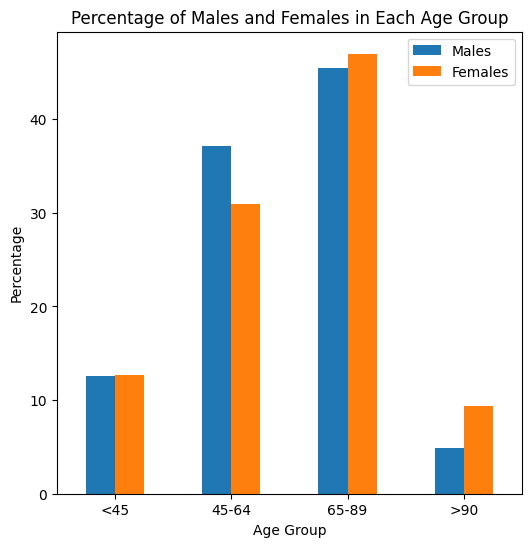

In [47]:
##AI-generated-code


import matplotlib.pyplot as plt

# Create a new dataframe that contains the percentages of males and females in each age group
df_plot = pd.DataFrame({'Males': percentage_males, 'Females': percentage_females})

# Create the double bar plot
df_plot.plot(kind='bar', figsize=(6, 6))

plt.title('Percentage of Males and Females in Each Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()
